# Digit Recognition
### MNIST Dataset 

In [43]:
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('./train.csv').values
test_data = pd.read_csv('./test.csv').values

In [3]:
# train_data 의 상태를 확인한다
train_data[:, :].shape

(42000, 785)

### 42000 개의 Instance, 785 = 1 (label) + 784(24*24) 의 픽셀로 구성되어 있는 것을 확인할 수 있다.

In [4]:
trainY = train_data[:,0]
trainY

array([1, 0, 1, ..., 7, 6, 9])

### Label 역할을 할 칼럼을 때어내었다. 숫자 데이터이므로, 연산 과정속에서 영향을 받지 않게 하기 위해, One-Hot 인코딩을 시행한다.

In [5]:
import keras.utils.np_utils as kutils

Using TensorFlow backend.


In [6]:
trainY = kutils.to_categorical(trainY)
trainY

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

### CNN 에 넣을꺼라면, 이미지의 원본 형태(2D) 형태로 돌려주어야 한다.

In [7]:
def make_config(img_row, img_col, filter_size=3, epoch=1, batch_size=128, layer_filter1=32, layer_filter2=64, layer_filter3=128):
    config_dict = {
        "epoch":epoch,
        "batch_size":batch_size,
        "img_row":img_row,
        "img_col":img_col,
        "filter_size":filter_size,
        "filter1":layer_filter1,
        "filter2":layer_filter2,
        "filter3":layer_filter3,
    }
    return config_dict

In [8]:
config = make_config(28, 28)
config

{'batch_size': 128,
 'epoch': 1,
 'filter1': 32,
 'filter2': 64,
 'filter3': 128,
 'filter_size': 3,
 'img_col': 28,
 'img_row': 28}

In [9]:
trainX = train_data[:,1:].reshape(train_data.shape[0], config['img_row'], config['img_col'], 1) # 흑백사진 이기 때문에 칼라코드는 1 이다
trainX.shape

(42000, 28, 28, 1)

### MNIST 는 0~9 까지의 10개의 클래스를 가지고 있다.

In [10]:
class_size = trainY.shape[1]
class_size

10

### 순차모델을 하나 만든다.

In [11]:
import keras.models as kmodel

In [12]:
cnn1 = kmodel.Sequential()
cnn1

In [13]:
cnn1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Total params: 0
____________________________________________________________________________________________________


### 당연하지만 처음에는 이 모델에 레이어가 없이 깨끗하다.

## Backend 에 돌고 있는 프레임워크의 image_dim_ordering 을 확인해보아야 한다.

In [14]:
from keras.backend import image_dim_ordering
image_dim_ordering()

'tf'

### image_dim_ordering: string, either "tf" or "th". 
It specifies which dimension ordering convention Keras will follow.
* For 2D data (e.g. image), "tf" assumes (rows, cols, channels) 
* while "th" assumes (channels, rows, cols).
* For 3D data, "tf" assumes (conv_dim1, conv_dim2, conv_dim3, channels) 
* while "th" assumes  (channels, conv_dim1, conv_dim2, conv_dim3).

https://keras.io/backend/

In [15]:
import keras.layers.convolutional as conv

In [16]:
cnn1.add(conv.Convolution2D(config['filter1'], config['filter_size'], config['filter_size'], 
                            activation='relu', input_shape=(config['img_row'], config['img_col'], 1), border_mode='same'))

In [18]:
cnn1.add(conv.Convolution2D(config['filter1'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))

In [20]:
cnn1.add(conv.MaxPooling2D(strides=(2,2))) # 2*2칸중 가장 큰 값으로 정한다

In [21]:
cnn1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 28, 28, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 32)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 32)    0           convolution2d_2[0][0]            
Total params: 9568
____________________________________________________________________________________________________


In [22]:
# L2
cnn1.add(conv.Convolution2D(config['filter2'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.Convolution2D(config['filter2'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.MaxPooling2D(strides=(2,2)))
cnn1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 28, 28, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 32)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 32)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 14, 14, 64)    18496       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [23]:
import keras.layers.core as core

### 7*7까지 만들었으니, 더이상 줄이기는 힘들다. 여기서 Fully Connected 로 연결한다.

In [24]:
cnn1.add(core.Flatten()) # 내용물을 1차원으로 쭉 피는 역할을 한다
cnn1.add(core.Dense(128, activation='relu')) # Fully Connected Layer. 뉴런의 갯수는 128로 한다.

In [25]:
cnn1.add(core.Dense(class_size, activation='softmax')) # Fully Connected Softmax 로 마지막에 클래스별 확률값을 구해낸다.
cnn1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 28, 28, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 32)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 32)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 14, 14, 64)    18496       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

### crossentropy 방식으로 loss 함수를 구할것이고, adam optimizer 를 이용한다.

In [26]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn1

In [27]:
cnn1.fit(trainX, trainY, batch_size=config['batch_size'], nb_epoch=config['epoch'], verbose=1)

Epoch 1/1
42000/42000 [==============================] - 231s - loss: 0.1470 - acc: 0.9527   


In [29]:
testX = test_data.reshape(test_data.shape[0], config['img_row'], config['img_col'], 1)
testX.shape

(28000, 28, 28, 1)

In [30]:
yPred = cnn1.predict_classes(testX)

28000/28000 [==============================] - 57s    


In [31]:
yPred

array([2, 0, 9, ..., 3, 9, 2])

In [41]:
image = testX[0,:].reshape(28,28)

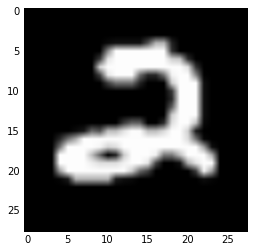

In [47]:
from matplotlib import pyplot as plt
plt.imshow(image, cmap='gray')
plt.show()

In [55]:
# from scipy.misc import toimage
# toimage(image).show()